# Equal Access to Cash in the context of the 20 Minute Neighbourhood

### Chuang Wang    Jianan Wei    Iain Paton

## Urban Analytics Group Project 2022-2023

Equal access to cash is an issue identified within the context of the 20 minute neighbourhood, alongside other factors (Olsen, Thornton, Tregonning, Mitchell 2022) with prior analysis that indicates 4.6% of the UK population do not have access to a free-to-use cash machine (ATM) and are required to pay a transaction fee for withdrawing cash (Financial Conduct Authority 2021). This issue may have a disproportionate impact upon poorer people, who may have a greater reliance upon cash transactions, and this analysis investigates the relationship between deprivation and access to cash, in the context of industry subsidy schemes for ATM access (the LINK network) and further interventions to support community access to cash.

Data sources

Method


The conclusion is that  


## References

Jonathan R. Olsen, Lukar Thornton, Grant Tregonning, Richard Mitchell, 'Nationwide equity assessment of the 20-min neighbourhood in the Scottish context: A socio-spatial proximity analysis of residential locations', Social Science & Medicine, Volume 315, 2022.
House of Commons Library, 'Statistics on Access to Cash, Bank Branches and ATMs'. UK Parliment, London, UK, 2022.


## Data sources


Virtual environment my37env for geopandas

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from IPython.display import Markdown, display
import shapefile
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import urllib3
import seaborn as sns
import contextily as ctx
from pandas import Series, DataFrame
from shapely.geometry import Point
from shapely.geometry import shape  
from zipfile import ZipFile
from io import StringIO
import scipy
from scipy import stats
from scipy.stats import norm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from IPython.core.display import HTML
table_css = 'table {align:left;display:block} '
HTML('<style>{}</style>'.format(table_css))

%matplotlib inline

## 1a. Data: Cash Machines/ATMs
This dataset is published by the LINK network and categorises ATMs as "free" or "surcharging".

Bold text (**Figure 1.1**) 

In [4]:
atm_data = pd.read_csv('cashpoint_xy.csv')



The dataset columns are listed below in **Figure 1.1.**

In [6]:
print('\033[1m'+ "Figure 1.1. ATM Data Fields" + '\033[0m')
atm_data.columns

Figure 1.1. ATM Data Fields


Index(['x', 'y', 'Street Address', 'Postcode', 'Charge Type'], dtype='object')

In [7]:
print('\033[1m' + "Figure 1.2. atm" + '\033[0m' )
print(atm_data['Charge Type'].value_counts())

Figure 1.2. atm
Free           4049
Surcharging    1026
Name: Charge Type, dtype: int64


The data is plotted spatially below in **Figure 1.3.** and this provides an indication of the spatial distribution, prior to joining with socio-economic data.

C:\ProgramData\Anaconda3\envs\my37env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


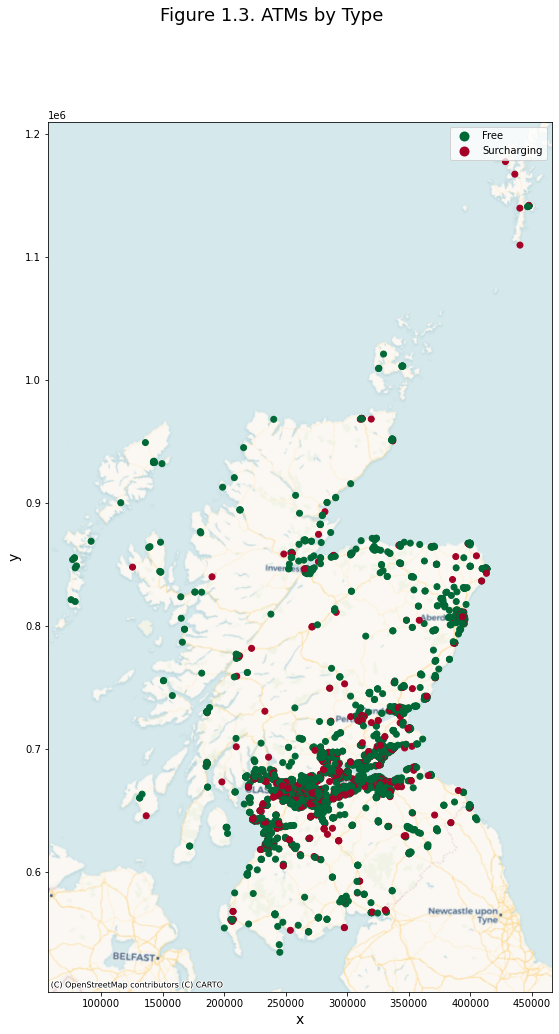

In [9]:
fig, ax = plt.subplots(figsize=(32,16))
geometry = [Point(xy) for xy in zip(atm_data['x'], atm_data['y'])]
crs = {'init': 'epsg:27700'}
atm_geodata = gpd.GeoDataFrame(atm_data, crs=crs, geometry=geometry)
plt.suptitle('Figure 1.3. ATMs by Type', fontsize=18)
plt.ylabel('y',fontsize=14)
plt.xlabel('x',fontsize=14)
atm_geodata.plot(ax=ax, column = 'Charge Type',cmap = 'RdYlGn_r',label = 'Charge Type', legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager,crs='EPSG:27700')
plt.show()

## 1b. Data: SIMD

The Scottish Index of Multiple Deprivation (SIMD) is a relative and area-based measure of deprivation across 6,976 small area data zones. SIMD ranks data zones from most deprived (ranked 1) to least deprived (ranked 6,976) across a number of categories - income, employment, education, health, access to services, crime and housing - which also includes an aggregate ranking and is commonly arranged in deciles or quintiles.

This dataset will be spatially joined to the prior STATS19 dataset, which contains some socio-economic information, but not the full range of that within SIMD nor the individual datazone rankings.

The columns and a summary table description are shown below (**Figure 1.4** and **Figure 1.5**), prior to a visualisation of the data.


In [10]:
url = "https://maps.gov.scot/ATOM/shapefiles/SG_SIMD_2020.zip"
simdmap_df = gpd.read_file(url)
print('\033[1m' +"Figure 1.4. SIMD columns"+'\033[0m' )
simdmap_df.columns

Figure 1.4. SIMD columns


Index(['DataZone', 'DZName', 'LAName', 'SAPE2017', 'WAPE2017', 'Rankv2',
       'Quintilev2', 'Decilev2', 'Vigintilv2', 'Percentv2', 'IncRate',
       'IncNumDep', 'IncRankv2', 'EmpRate', 'EmpNumDep', 'EmpRank', 'HlthCIF',
       'HlthAlcSR', 'HlthDrugSR', 'HlthSMR', 'HlthDprsPc', 'HlthLBWTPc',
       'HlthEmergS', 'HlthRank', 'EduAttend', 'EduAttain', 'EduNoQuals',
       'EduPartici', 'EduUniver', 'EduRank', 'GAccPetrol', 'GAccDTGP',
       'GAccDTPost', 'GAccDTPsch', 'GAccDTSsch', 'GAccDTRet', 'GAccPTGP',
       'GAccPTPost', 'GAccPTRet', 'GAccBrdbnd', 'GAccRank', 'CrimeCount',
       'CrimeRate', 'CrimeRank', 'HouseNumOC', 'HouseNumNC', 'HouseOCrat',
       'HouseNCrat', 'HouseRank', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

In [11]:
print('\033[1m' +"Figure 1.5. SIMD description"+'\033[0m' )
simdmap_df.describe()

Figure 1.5. SIMD description


,SAPE2017,WAPE2017,Rankv2,Quintilev2,Decilev2,Vigintilv2,Percentv2,IncNumDep,IncRankv2,EmpNumDep,...,GAccPTRet,GAccRank,CrimeCount,CrimeRate,CrimeRank,HouseNumOC,HouseNumNC,HouseRank,Shape_Leng,Shape_Area
count,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,...,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6.976000e+03
mean,777.637615,500.973481,3488.500000,3.000287,5.500573,10.501147,50.506881,93.830419,3488.497420,46.558343,...,13.546277,3488.500000,22.303039,287.598767,3488.500000,82.332569,13.430619,3488.500000,11796.930969,1.117218e+07
std,219.108923,175.075939,2013.942071,1.414416,2.872487,5.766595,28.868218,76.620587,2013.937591,37.060114,...,10.709859,2013.942071,32.849022,404.842613,2013.939363,63.921332,16.800241,2013.942063,34514.362402,5.656366e+07
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,1.840000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,561.481470,9.367268e+03
25%,635.000000,395.000000,1744.750000,2.000000,3.000000,5.750000,25.750000,34.000000,1744.750000,18.000000,...,7.980000,1744.750000,7.000000,94.000000,1744.750000,35.000000,3.000000,1744.750000,2196.306838,1.336901e+05
50%,755.000000,475.000000,3488.500000,3.000000,5.500000,10.500000,50.500000,72.000000,3488.500000,36.000000,...,11.250000,3488.500000,14.000000,194.000000,3488.500000,66.500000,8.000000,3488.500000,2968.399829,2.111272e+05
75%,886.000000,568.000000,5232.250000,4.000000,8.000000,15.250000,75.250000,133.000000,5232.250000,65.000000,...,16.060000,5232.250000,28.000000,361.000000,5232.250000,112.000000,17.000000,5232.250000,4654.186576,4.141899e+05
max,3847.000000,3423.000000,6976.000000,5.000000,10.000000,20.000000,100.000000,656.000000,6969.000000,311.000000,...,190.000000,6976.000000,1159.000000,12441.000000,6928.000000,490.000000,187.000000,6974.000000,893824.142207,1.162510e+09


SIMD is visualised spatially below in **Figure 1.6**.

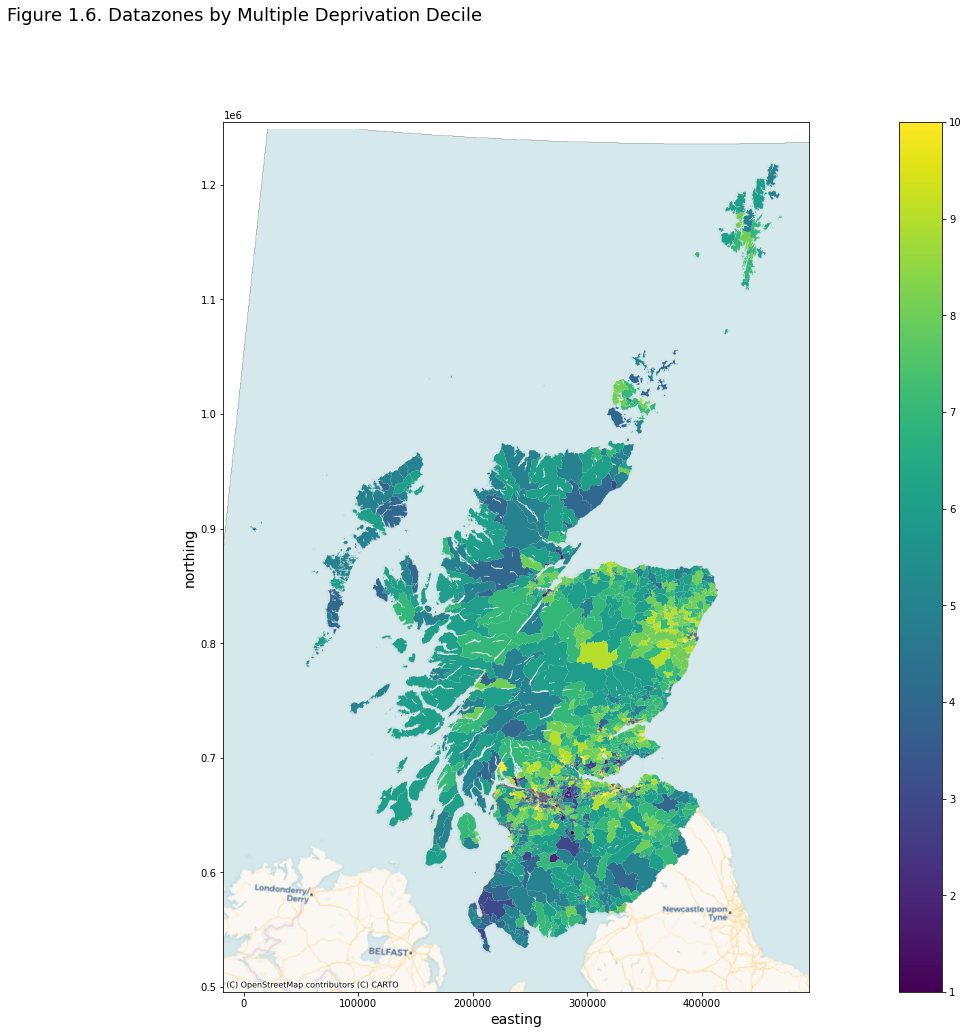

In [12]:
fig, ax = plt.subplots(figsize=(32,16))
plt.suptitle('Figure 1.6. Datazones by Multiple Deprivation Decile', fontsize=18)
plt.ylabel('northing',fontsize=14)
plt.xlabel('easting',fontsize=14)
simdmap_df.plot(ax=ax, column='Decilev2', linewidth = 0.1, legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager,crs='EPSG:27700')


# 1c. Data: Postcode Centroids

The postcode is the lowest-level postal address area geometry unit (other than the unique property reference number or UPRN, a building level of geometry). The use of associated postcode centroids provides sufficient granularity for an equivalent to residential population, in catchment analysis.

The headings and summary statistics are shown in **Figures 1.7 and 1.8** below.

In order to derive a subset of postcode centroids representing residential delivery points, the data is filtered for "RP" (residential delivery points) values greater than zero. This process is shown in **Figures 1.9 and 1.10** below.

The resultant postcode centroids are mapped by easting and northing in **Figure 1.11** below.

In [13]:
postcode_centroids = pd.concat(map(pd.read_csv, ['ab.csv', 'dd.csv','dg.csv','eh.csv', 'fk.csv','g.csv','hs.csv', 'iv.csv','ka.csv','kw.csv','ky.csv','ml.csv','pa.csv','ph.csv','td.csv','ze.csv']))

In [16]:
print('\033[1m'+ "Figure 1.7. Postcode Centroid Data Fields" + '\033[0m')
postcode_centroids.columns

Figure 1.7. Postcode Centroid Data Fields


Index(['PC', 'PQ', 'PR', 'TP', 'DQ', 'RP', 'BP', 'PD', 'MP', 'UM', 'EA', 'NO',
       'CY', 'RH', 'LH', 'CC', 'DC', 'WC', 'LS'],
      dtype='object')

In [17]:
print('\033[1m' +"Figure 1.8. Postcode Centroids"+'\033[0m' )
postcode_centroids.describe()

Figure 1.8. Postcode Centroids


,PQ,TP,DQ,RP,BP,PD,MP,UM,EA,NO
count,160768.000000,160768.000000,160768.000000,160768.000000,160768.000000,160768.000000,160768.000000,160768.000000,160768.000000,1.607680e+05
mean,10.086460,17.678207,17.548455,16.964390,0.702553,0.011265,17.548455,0.129752,296229.878483,7.020987e+05
std,1.914398,15.745038,15.709437,15.757967,2.369294,0.105536,15.709437,1.307336,53222.856305,8.286128e+04
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,10.000000,6.000000,5.000000,5.000000,0.000000,0.000000,5.000000,0.000000,257412.000000,6.610948e+05
50%,10.000000,13.000000,13.000000,12.000000,0.000000,0.000000,13.000000,0.000000,290618.500000,6.729950e+05
75%,10.000000,26.000000,26.000000,25.000000,0.000000,0.000000,26.000000,0.000000,331482.000000,7.300795e+05
max,90.000000,100.000000,100.000000,100.000000,85.000000,1.000000,100.000000,84.000000,468851.000000,1.213615e+06


In [19]:
print('\033[1m' + "Figure 1.9. Postcode Centroids Residential Delivery PointsCounts" + '\033[0m' )
print(postcode_centroids['RP'].value_counts())

Figure 1.9. Postcode Centroids Residential Counts
0      12042
4       7404
1       6956
8       6688
6       6475
       ...  
98         9
95         8
97         8
100        7
99         5
Name: RP, Length: 101, dtype: int64


In [20]:
postcode_centroids = postcode_centroids[postcode_centroids['RP'] >0]

In [22]:
print('\033[1m' + "Figure 1.10 Postcode Centroids - Residential Delivery Points >0" + '\033[0m' )
print(postcode_centroids['RP'].value_counts())

Figure 1.10 Postcode Centroids - Residential Delivery Points >0
4      7404
1      6956
8      6688
6      6475
2      6385
       ... 
98        9
97        8
95        8
100       7
99        5
Name: RP, Length: 100, dtype: int64


C:\ProgramData\Anaconda3\envs\my37env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


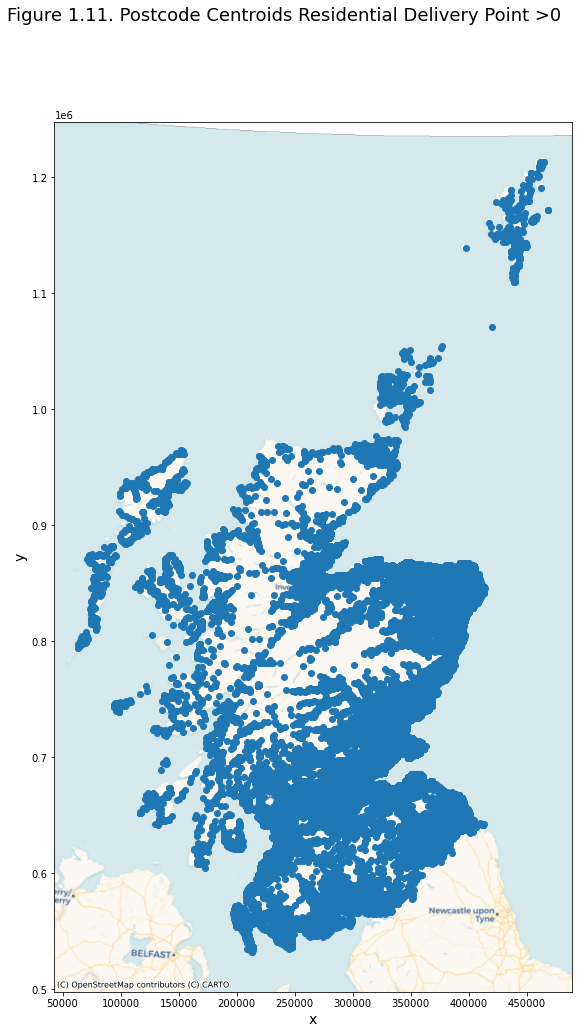

In [24]:
fig, ax = plt.subplots(figsize=(32,16))
geometry = [Point(xy) for xy in zip(postcode_centroids['EA'], postcode_centroids['NO'])]
crs = {'init': 'epsg:27700'}
postcode_centroids_geodata = gpd.GeoDataFrame(postcode_centroids, crs=crs, geometry=geometry)
plt.suptitle('Figure 1.11. Postcode Centroids Residential Delivery Point >0', fontsize=18)
plt.ylabel('y',fontsize=14)
plt.xlabel('x',fontsize=14)
postcode_centroids_geodata.plot(ax=ax, legend=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager,crs='EPSG:27700')
plt.show()

# 1d. Data: Joining Postcode Centroids to SIMD by Location¶

In order to provide an evidential basis in terms of deprivation, SIMD is spatially joined to postcode centroids. This is shown at Figure 1.12 below.


In [27]:
postcode_simd_join = gpd.sjoin(postcode_centroids_geodata, simdmap_df, how='inner',op = 'intersects')

In [32]:
postcode_simd_join.columns

Index(['PC', 'PQ', 'PR', 'TP', 'DQ', 'RP', 'BP', 'PD', 'MP', 'UM', 'EA', 'NO',
       'CY', 'RH', 'LH', 'CC', 'DC', 'WC', 'LS', 'geometry', 'index_right',
       'DataZone', 'DZName', 'LAName', 'SAPE2017', 'WAPE2017', 'Rankv2',
       'Quintilev2', 'Decilev2', 'Vigintilv2', 'Percentv2', 'IncRate',
       'IncNumDep', 'IncRankv2', 'EmpRate', 'EmpNumDep', 'EmpRank', 'HlthCIF',
       'HlthAlcSR', 'HlthDrugSR', 'HlthSMR', 'HlthDprsPc', 'HlthLBWTPc',
       'HlthEmergS', 'HlthRank', 'EduAttend', 'EduAttain', 'EduNoQuals',
       'EduPartici', 'EduUniver', 'EduRank', 'GAccPetrol', 'GAccDTGP',
       'GAccDTPost', 'GAccDTPsch', 'GAccDTSsch', 'GAccDTRet', 'GAccPTGP',
       'GAccPTPost', 'GAccPTRet', 'GAccBrdbnd', 'GAccRank', 'CrimeCount',
       'CrimeRate', 'CrimeRank', 'HouseNumOC', 'HouseNumNC', 'HouseOCrat',
       'HouseNCrat', 'HouseRank', 'Shape_Leng', 'Shape_Area'],
      dtype='object')

<AxesSubplot:>

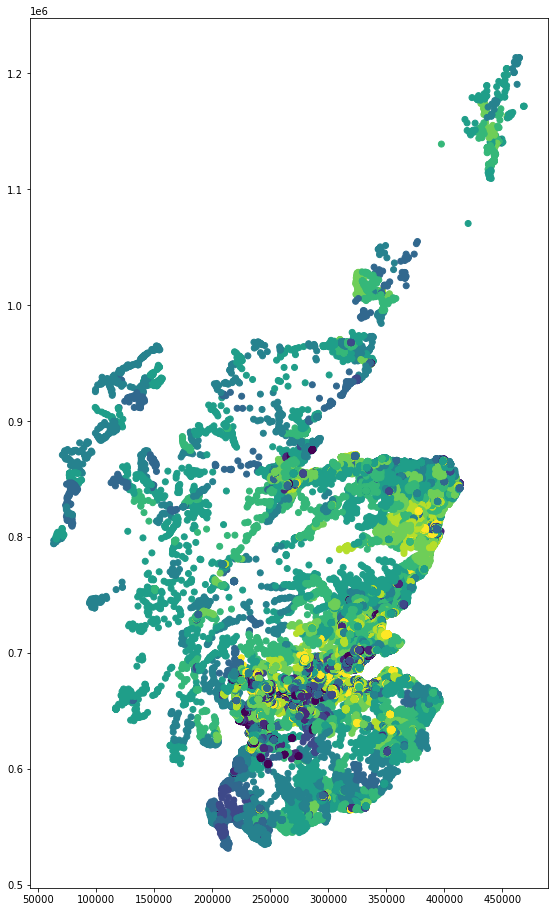

In [34]:
postcode_simd_join.plot(column='Decilev2',figsize =(18,16))